<a href="https://colab.research.google.com/github/solos001/Rock-Paper-Scissor-Game/blob/master/predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [93]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [94]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-03-22 16:11:07--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2022-03-22 16:11:07 (94.2 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [95]:
dataset.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [96]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [97]:
dataset['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [98]:
dataset.sex.unique()

array(['female', 'male'], dtype=object)

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [100]:
def data_proc(data):
  X=data.drop('expenses',axis=1)
  y=data.expenses

  num_attribs=X.select_dtypes(exclude="object").columns
  cat_attribs=X.select_dtypes(include="object").columns

  num_pipeline=Pipeline([('std_scaler', StandardScaler())])
  full_pipeline=ColumnTransformer([('num',num_pipeline,num_attribs),('cat',OneHotEncoder(),cat_attribs)])
  X_prepared=full_pipeline.fit_transform(X)
  

  
  X_train,X_test,y_train,y_test=train_test_split(X_prepared,y,train_size=0.8,test_size=0.2,random_state=0)
  y_test=y_test.to_numpy()
  y_train=y_train.to_numpy()
  return X_train,X_test,y_train,y_test


In [101]:
X_train,X_test,y_train,y_test=data_proc(dataset.copy())

In [102]:
def build_nn_model(n_hidden=4, n_neurons=100, learning_rate=0.001, input_shape=X_train.shape[1:],bn=False,dropout=False):
  model=keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=input_shape))
  if dropout:
      model.add(keras.layers.Dropout(rate=0.2))
  if bn:
      model.add(keras.layers.BatchNormalization())
  for hidden_layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons,kernel_initializer="he_normal",activation="selu"))
    if bn:
      model.add(keras.layers.BatchNormalization())
    if dropout:
      model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(1))
  adam_optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
  model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=adam_optimizer,
                metrics=[tf.keras.metrics.MeanAbsoluteError()])  
  return model

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [104]:
param_distribs = {
  "n_hidden": [1,2,3,4],
  "n_neurons": np.arange(1,100),
}
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_nn_model)
search_cv = RandomizedSearchCV(keras_reg, param_distribs,n_iter=5,cv=3,scoring='neg_mean_absolute_error')
search_cv.fit(X_train, y_train, epochs=400,validation_split=0.2,callbacks=[keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)])

Epoch 1/400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
18/18 [==============================] - 0s 5ms/step - loss: 4987.7480 - mean_absolute_error: 4987.7480 - val_loss: 7000.8154 - val_mean_absolute_error: 7000.8154
Epoch 166/400
18/18 [==============================] - 0s 5ms/step - loss: 4967.0742 - mean_absolute_error: 4967.0742 - val_loss: 6975.3374 - val_mean_absolute_error: 6975.3374
Epoch 167/400
18/18 [==============================] - 0s 5ms/step - loss: 4945.8872 - mean_absolute_error: 4945.8872 - val_loss: 6949.7822 - val_mean_absolute_error: 6949.7822
Epoch 168/400
18/18 [==============================] - 0s 6ms/step - loss: 4923.9590 - mean_absolute_error: 4923.9590 - val_loss: 6926.8853 - val_mean_absolute_error: 6926.8853
Epoch 169/400
18/18 [==============================] - 0s 6ms/step - loss: 4902.4531 - mean_absolute_error: 4902.4531 - val_loss: 6899.7803 - val_mean_absolute_error: 6899.7803
Epoch 170/400
18/18 [==============================

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f3cad45bb50>,
                   n_iter=5,
                   param_distributions={'n_hidden': [1, 2, 3, 4],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   scoring='neg_mean_absolute_error')

In [105]:
search_cv.best_params_

{'n_hidden': 3, 'n_neurons': 57}

In [106]:
model_1 = search_cv.best_estimator_.model
model_1.evaluate(X_test,y_test)

9/9 [==============================] - 0s 2ms/step - loss: 1651.3175 - mean_absolute_error: 1651.3175


[1651.3175048828125, 1651.3175048828125]

In [107]:
model_1_error=model_1.evaluate(X_test,y_test)[0]

9/9 [==============================] - 0s 2ms/step - loss: 1651.3175 - mean_absolute_error: 1651.3175


In [108]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [109]:
def build_linear(X,y):
  ridge=Ridge()
  params={'alpha':[1,5,10,30]}
  grid=GridSearchCV(estimator=ridge,param_grid=params,cv=3,scoring='neg_mean_absolute_error')
  grid.fit(X,y)
  return grid.best_estimator_

In [110]:
model_2=build_linear(X_train,y_train)

In [111]:
from sklearn.metrics import mean_absolute_error
model_2_error=mean_absolute_error(y_test,model_2.predict(X_test))

In [112]:
import xgboost

In [113]:
def build_xgboost(X,y):
  X_train_,X_val,y_train_,y_val=train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)
  xgb_reg = xgboost.XGBRegressor(random_state=0,learning_rate=0.1)
  # params={'learning_rate':[0.1,0.05,0.001],'reg_alpha':[1]}
  # grid=GridSearchCV(estimator=xgb_reg,param_grid=params,cv=3)
  # grid.fit(X_train_,y_train_,eval_set=[(X_val, y_val)], early_stopping_rounds=10,eval_metric='mse')
  xgb_reg.fit(X,y,eval_set=[(X_val, y_val)], early_stopping_rounds=10,eval_metric='mae')
  return xgb_reg

In [114]:
model_3=build_xgboost(X_train,y_train)

[16:24:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11345.9
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:10243.6
[2]	validation_0-mae:9235.61
[3]	validation_0-mae:8338.46
[4]	validation_0-mae:7529.09
[5]	validation_0-mae:6809.76
[6]	validation_0-mae:6184.41
[7]	validation_0-mae:5614.74
[8]	validation_0-mae:5114.89
[9]	validation_0-mae:4670.95
[10]	validation_0-mae:4276.35
[11]	validation_0-mae:3917.18
[12]	validation_0-mae:3622.53
[13]	validation_0-mae:3351.64
[14]	validation_0-mae:3137.13
[15]	validation_0-mae:2947.53
[16]	validation_0-mae:2800.9
[17]	validation_0-mae:2669.54
[18]	validation_0-mae:2573.99
[19]	validation_0-mae:2491.28
[20]	validation_0-mae:2430.6
[21]	validation_0-mae:2377.07
[22]	validation_0-mae:2343.49
[23]	validation_0-mae:2319.43
[24]	validation_0-mae:2295.98
[25]	validation_0-mae:2280.67
[26]	validation_0-mae:2271.49
[27]	valida

In [115]:
model_3_error=mean_absolute_error(y_test,model_3.predict(X_test))

In [116]:
error={'Neural_Networks':round(model_1_error,2),
       'RidgeRegression':round(model_2_error,2),
       'XgboostRegressor':round(model_3_error,2)
       }

In [117]:
error_data=pd.Series(error)

In [118]:
error_data.keys()

Index(['Neural_Networks', 'RidgeRegression', 'XgboostRegressor'], dtype='object')

In [119]:
error_data.values

array([1651.32, 3939.18, 2230.72])

Text(0.5, 1.0, 'Models benchmark')

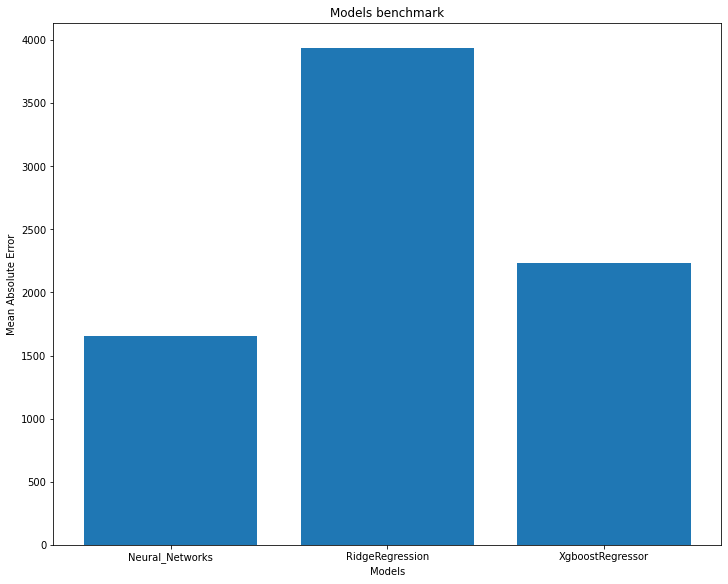

In [120]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
ax.bar(error_data.keys(),error_data.values)
ax.set_xlabel('Models')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Models benchmark')

In [121]:
model=model_1

9/9 - 0s - loss: 1651.3175 - mean_absolute_error: 1651.3175 - 37ms/epoch - 4ms/step
Testing set Mean Abs Error: 1651.32 expenses
You passed the challenge. Great job!


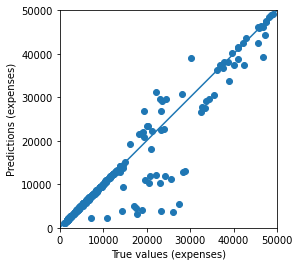

In [122]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae= model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
